In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [193]:
df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [194]:
#Truncate time stamps to day using floor
df['time_stamp'] = df['time_stamp'].dt.floor('d').astype(np.int64)
#Sort by user id and day and drop duplicates 
df = df.sort_values(['user_id', 'time_stamp']).drop_duplicates()

#Get users who logged in on at least 3 days over a week
a = df.groupby('user_id')['time_stamp'].rolling(window=3)
b = pd.to_timedelta((a.max()- a.min())).dt.days
c = b[b == 7].index.get_level_values('user_id').tolist()
#Remove duplicate users
adopted_users_list = list(set(c))

In [195]:
df = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
#Create column for whether user is an adopted user
df['adopted_user'] = df.object_id.isin(adopted_users_list)
df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,False
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,False
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,False
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,False
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,True


In [196]:
#Check for null values
df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
dtype: int64

In [197]:
#Fill in 0 for users who weren't invited
df['invited_by_user_id'].fillna(0, inplace=True)

#Replace null values with earliest session login time
df['last_session_creation_time'].fillna(min(df['last_session_creation_time']), inplace=True)

In [198]:
def categorical_bar_graph(df, column_name):
    
    cross_tab = pd.crosstab(df[column_name], df['adopted_user'])

    num_categories = len(cross_tab.index)
    x_vals = np.arange(num_categories) + 1
    x_labels = cross_tab.index.values

    y_vals = np.empty(num_categories)
    for i in range(num_categories):
        y_vals[i] = cross_tab.iloc[i,1] / np.sum(cross_tab.iloc[i,0:2])
        
    return x_labels, x_vals, y_vals

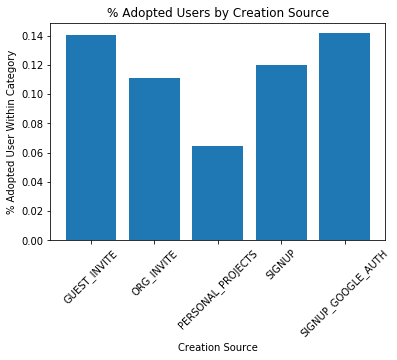

In [199]:
#Create bar graph for creation sources
x_labels, x, y = categorical_bar_graph(df, 'creation_source')

plt.bar(x, y)
plt.title('% Adopted Users by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('% Adopted User Within Category')
plt.xticks(x_vals, x_labels, rotation=45)
plt.show()

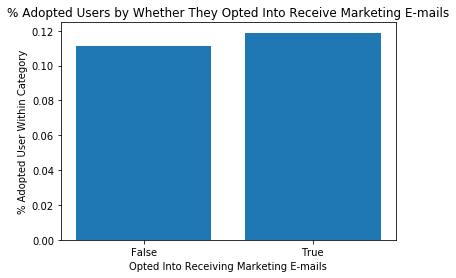

In [200]:
#Create bar graph for whether a user opted into mailing list
_, x, y = categorical_bar_graph(df, 'opted_in_to_mailing_list')

plt.bar(x, y)
plt.title('% Adopted Users by Whether They Opted Into Receive Marketing E-mails')
plt.xlabel('Opted Into Receiving Marketing E-mails')
plt.ylabel('% Adopted User Within Category')
plt.xticks(x, [False, True])
plt.show()

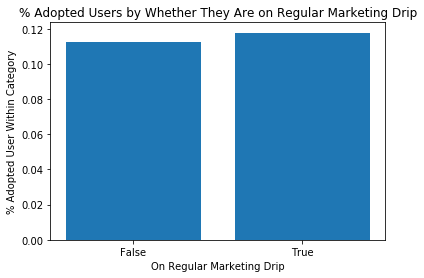

In [201]:
#Create bar graph for whether user is on regular marketing email drip
_, x, y = categorical_bar_graph(df, 'enabled_for_marketing_drip')

plt.bar(x, y)
plt.title('% Adopted Users by Whether They Are on Regular Marketing Drip')
plt.xlabel('On Regular Marketing Drip')
plt.ylabel('% Adopted User Within Category')
plt.xticks(x, [False, True])
plt.show()

In [202]:
#Transform creation time to days since first creation day
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['creation_time_delta'] = (df['creation_time'] - df['creation_time'].min())  / np.timedelta64(1,'D')

In [204]:
log_columns = ['creation_time_delta', 'last_session_creation_time', 'opted_in_to_mailing_list', 
               'enabled_for_marketing_drip']

dfx = df.loc[:, log_columns]

dummy_creation_source = pd.get_dummies(df['creation_source'], drop_first=True)
dfx = pd.concat([dfx, dummy_creation_source], axis=1)

In [205]:
import statsmodels.formula.api as sm

X = dfx.astype(float)
y = df.adopted_user

model = sm.Logit(y, X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.346145
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           adopted_user   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11992
Method:                           MLE   Df Model:                            7
Date:                Fri, 12 Oct 2018   Pseudo R-squ.:                 0.01965
Time:                        19:00:34   Log-Likelihood:                -4153.7
converged:                       True   LL-Null:                       -4237.0
                                        LLR p-value:                 1.335e-32
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
creation_time_delta           -0.0018      0.000    -13.242      0.000      -0.002      -0.002
last_session_creation_time -7.558e-10   5.76e-11    -13.127      0.000   -8.69e-10   -6.43e-10
opted_in_to_mailing_list       0.0358      0.076      0.473      0.636      -0.112       0.184
enabled_for_marketing_drip     0.0052      0.092      0.056      0.955      -0.175       0.186
ORG_INVITE                    -0.3751      0.078     -4.832      0.000      -0.527      -0.223
PERSONAL_PROJECTS             -1.0074      0.107     -9.429      0.000      -1.217      -0.798
SIGNUP                        -0.2743      0.091     -3.020      0.003      -0.452      -0.096
SIGNUP_GOOGLE_AUTH            -0.0865      0.099     -0.877      0.380      -0.280       0.107
==============================================================================================
"""

I created some bar graphs to see how some of our categorical variables affected the percentage of people within those categories who were considered adopted users. What I found was that some of the categories of creation source, particularly if the user was invited to join another user's workspace, were associated with differences in percentage of adopted users. In contrast, whether users opted into receiving marketing e-mails or whether they were on the regular marketing e-mail drip seemed to have no effect on user adoption. This was also confirmed by running a logistic regression model. The coefficient with the largest magnitude was the dummy variable corresponding to whether a user joined because they were invited to another user's workspace. The p-values for the boolean variables mentioned above were also extremely large, further supporting the idea that these variables have on bearing on user adoption. While creation time did have some effect on predicting our output variable, based on its low p-value, it also has a fairly small coefficient, which suggest that its effect might not be very significant. 